In this notebook we will be building and training LSTM to predict Netflix stock. We will use PyTorch.

## 1. Libraries and settings

In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
#plt.style.use('seaborn-paper')
# mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for i, filename in enumerate(filenames):
        if i<5:
            print(os.path.join(dirname,filename))


C:\Users\carle\AppData\Local\Temp\ipykernel_23352\3813858229.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
C:\Users\carle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Is cuda available for GPU computing?

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


## 2. Load data

In [3]:
import yfinance as yf
data = yf.download('NFLX', period='2y', interval='1d')

[*********************100%***********************]  1 of 1 completed


<Figure size 432x288 with 0 Axes>

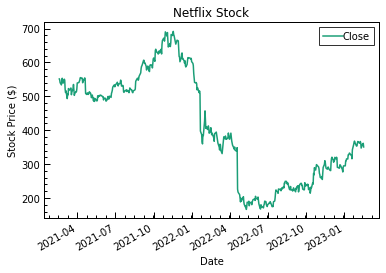

In [4]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Dark2.colors)
plt.figure()
data[['Close']].plot()
plt.ylabel("Stock Price ($)")
plt.xlabel("Date")
plt.title("Netflix Stock")
plt.savefig('netflixStock.png')
plt.show()

In [5]:
close=data[['Close']]
close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2021-02-17 to 2023-02-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   505 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB


In [6]:
close=close.fillna(method='ffill')

# Normalize input values to the range (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
close['Close'] = scaler.fit_transform(close['Close'].values.reshape(-1,1))

In [7]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

## 3. Build the structure of model

In [8]:
# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

# Study of look_back parameter

In [9]:
testRMSE = []
trainRMSE = []
lookBacks = np.linspace(2, 496, 30, dtype=int)

numModels = 10

for b in range(numModels):
    tests = []
    trains = []
    for look_back in lookBacks:
        # Create train and test sets
        ########################
        x_train, y_train, x_test, y_test = load_data(close, look_back)

        # make training and test sets in torch
        x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
        x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
        y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
        y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)



        # Build model
        #####################
        input_dim = 1
        hidden_dim = 50
        num_layers = 2
        output_dim = 1
            
        model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

        loss_fn = torch.nn.MSELoss()

        optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
        # print(model)
        # print(len(list(model.parameters())))
        # for i in range(len(list(model.parameters()))):
        #     print(list(model.parameters())[i].size())



        # Train model
        #####################
        num_epochs = 100
        hist = np.zeros(num_epochs)

        # Number of steps to unroll
        seq_dim =look_back-1  

        for t in range(num_epochs):
            # Initialise hidden state
            # Don't do this if you want your LSTM to be stateful
            #model.hidden = model.init_hidden()
            
            # Forward pass
            y_train_pred = model(x_train)

            loss = loss_fn(y_train_pred, y_train)
            # if t % 10 == 0 and t !=0:
            #     print("Epoch ", t, "MSE: ", loss.item())
            hist[t] = loss.item()

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss.backward()

            # Update parameters
            optimiser.step()


        # make predictions
        #######################
        y_test_pred = model(x_test)

        # invert predictions
        y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
        y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
        y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
        y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

        # calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
        trains.append(trainScore)
        testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
        tests.append(testScore)
    
    testRMSE.append(tests)
    trainRMSE.append(trains)

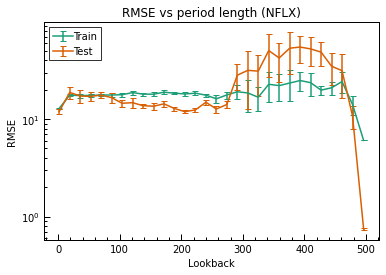

In [10]:
averageTrain = np.mean(trainRMSE, axis=0)
averageTest = np.mean(testRMSE, axis=0)
deviationTrain = np.std(trainRMSE, axis=0)
deviationTest = np.std(testRMSE, axis=0)

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Dark2.colors)
plt.figure()
plt.title('RMSE vs period length (NFLX)')
plt.xlabel('Lookback')
plt.ylabel('RMSE')
plt.errorbar(lookBacks, averageTrain, yerr=deviationTrain, capsize=3.0, label='Train')
plt.errorbar(lookBacks, averageTest, yerr=deviationTest, capsize=3.0, label='Test')
plt.yscale('log')
plt.legend()
plt.savefig('lookBackNetflix.png')
plt.show()